In [56]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from pycaret.regression import *
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


# 读取 historicalCongestion.csv 文件
congestion_df = pd.read_csv("historicalCongestion.csv")

# 读取 testDataconarr.csv 文件
testDataConArr_df = pd.read_csv("testDataconarr.csv")

# 读取 trainingDataconarr.csv 文件
trainingDataConArr_df = pd.read_csv("trainingDataconarr.csv")

# 读取 testDatatimings.csv 文件
testDataTimings_df = pd.read_csv("testDatatimings.csv")

# 读取 trainingDatatimings.csv 文件
trainingDataTimings_df = pd.read_csv("trainingDatatimings.csv")

def drop_first_column(df):#删除第一列
  # 使用 `drop()` 方法删除列
  # axis=1 表示删除列
  # inplace=False 表示不修改原 DataFrame，而是返回新的 DataFrame
  return df.drop(df.columns[:1], axis=1, inplace=False)

'''
# congestion_df = drop_first_column(congestion_df)
# testDataConArr_df = drop_first_column(testDataConArr_df)
# trainingDataConArr_df = drop_first_column(trainingDataConArr_df)
# testDataTimings_df = drop_first_column(testDataTimings_df)
# trainingDataTimings_df = drop_first_column(trainingDataTimings_df)
#把train.code列的名字改一下，为后续匹配做准备
# trainingDataConArr_df = trainingDataConArr_df.rename(columns={'train_code':'train.code'})
# testDataConArr_df = testDataConArr_df.rename(columns={'train_code':'train.code'})
#按照train.code的值匹配联表
# trainingDataTimings_df = trainingDataTimings_df.merge(trainingDataConArr_df,on = 'train.code',how='left')
# 生成索引列，我也不知道为什么
# trainingDataConArr_df = trainingDataConArr_df.reset_index()
# testDataConArr_df = testDataConArr_df.reset_index()
# #将表格合并一下
# trainingDataTimings_df = trainingDataTimings_df.merge(trainingDataConArr_df, left_on='id', right_on='index', how='left').drop('index',axis=1)
# testDataTimings_df = testDataTimings_df.merge(testDataConArr_df, left_on='id', right_on='index', how='left').drop('index',axis=1)
'''


"\n# congestion_df = drop_first_column(congestion_df)\n# testDataConArr_df = drop_first_column(testDataConArr_df)\n# trainingDataConArr_df = drop_first_column(trainingDataConArr_df)\n# testDataTimings_df = drop_first_column(testDataTimings_df)\n# trainingDataTimings_df = drop_first_column(trainingDataTimings_df)\n#把train.code列的名字改一下，为后续匹配做准备\n# trainingDataConArr_df = trainingDataConArr_df.rename(columns={'train_code':'train.code'})\n# testDataConArr_df = testDataConArr_df.rename(columns={'train_code':'train.code'})\n#按照train.code的值匹配联表\n# trainingDataTimings_df = trainingDataTimings_df.merge(trainingDataConArr_df,on = 'train.code',how='left')\n# 生成索引列，我也不知道为什么\n# trainingDataConArr_df = trainingDataConArr_df.reset_index()\n# testDataConArr_df = testDataConArr_df.reset_index()\n# #将表格合并一下\n# trainingDataTimings_df = trainingDataTimings_df.merge(trainingDataConArr_df, left_on='id', right_on='index', how='left').drop('index',axis=1)\n# testDataTimings_df = testDataTimings_df.merge(testDa

In [2]:
# 转换时间用的
def text_to_seconds(text_time):
  """
  Converts a time string in HH:MM:SS format to seconds.

  Args:
      text_time: The time string to convert.

  Returns:
      The time in seconds as an integer.
  """

  # Split the time string into hours, minutes, and seconds
  hours, minutes, seconds = map(int, text_time.split(":"))

  # Convert each unit to seconds and sum them up
  return hours * 3600 + minutes * 60 + seconds


<Figure size 10000x6000 with 0 Axes>

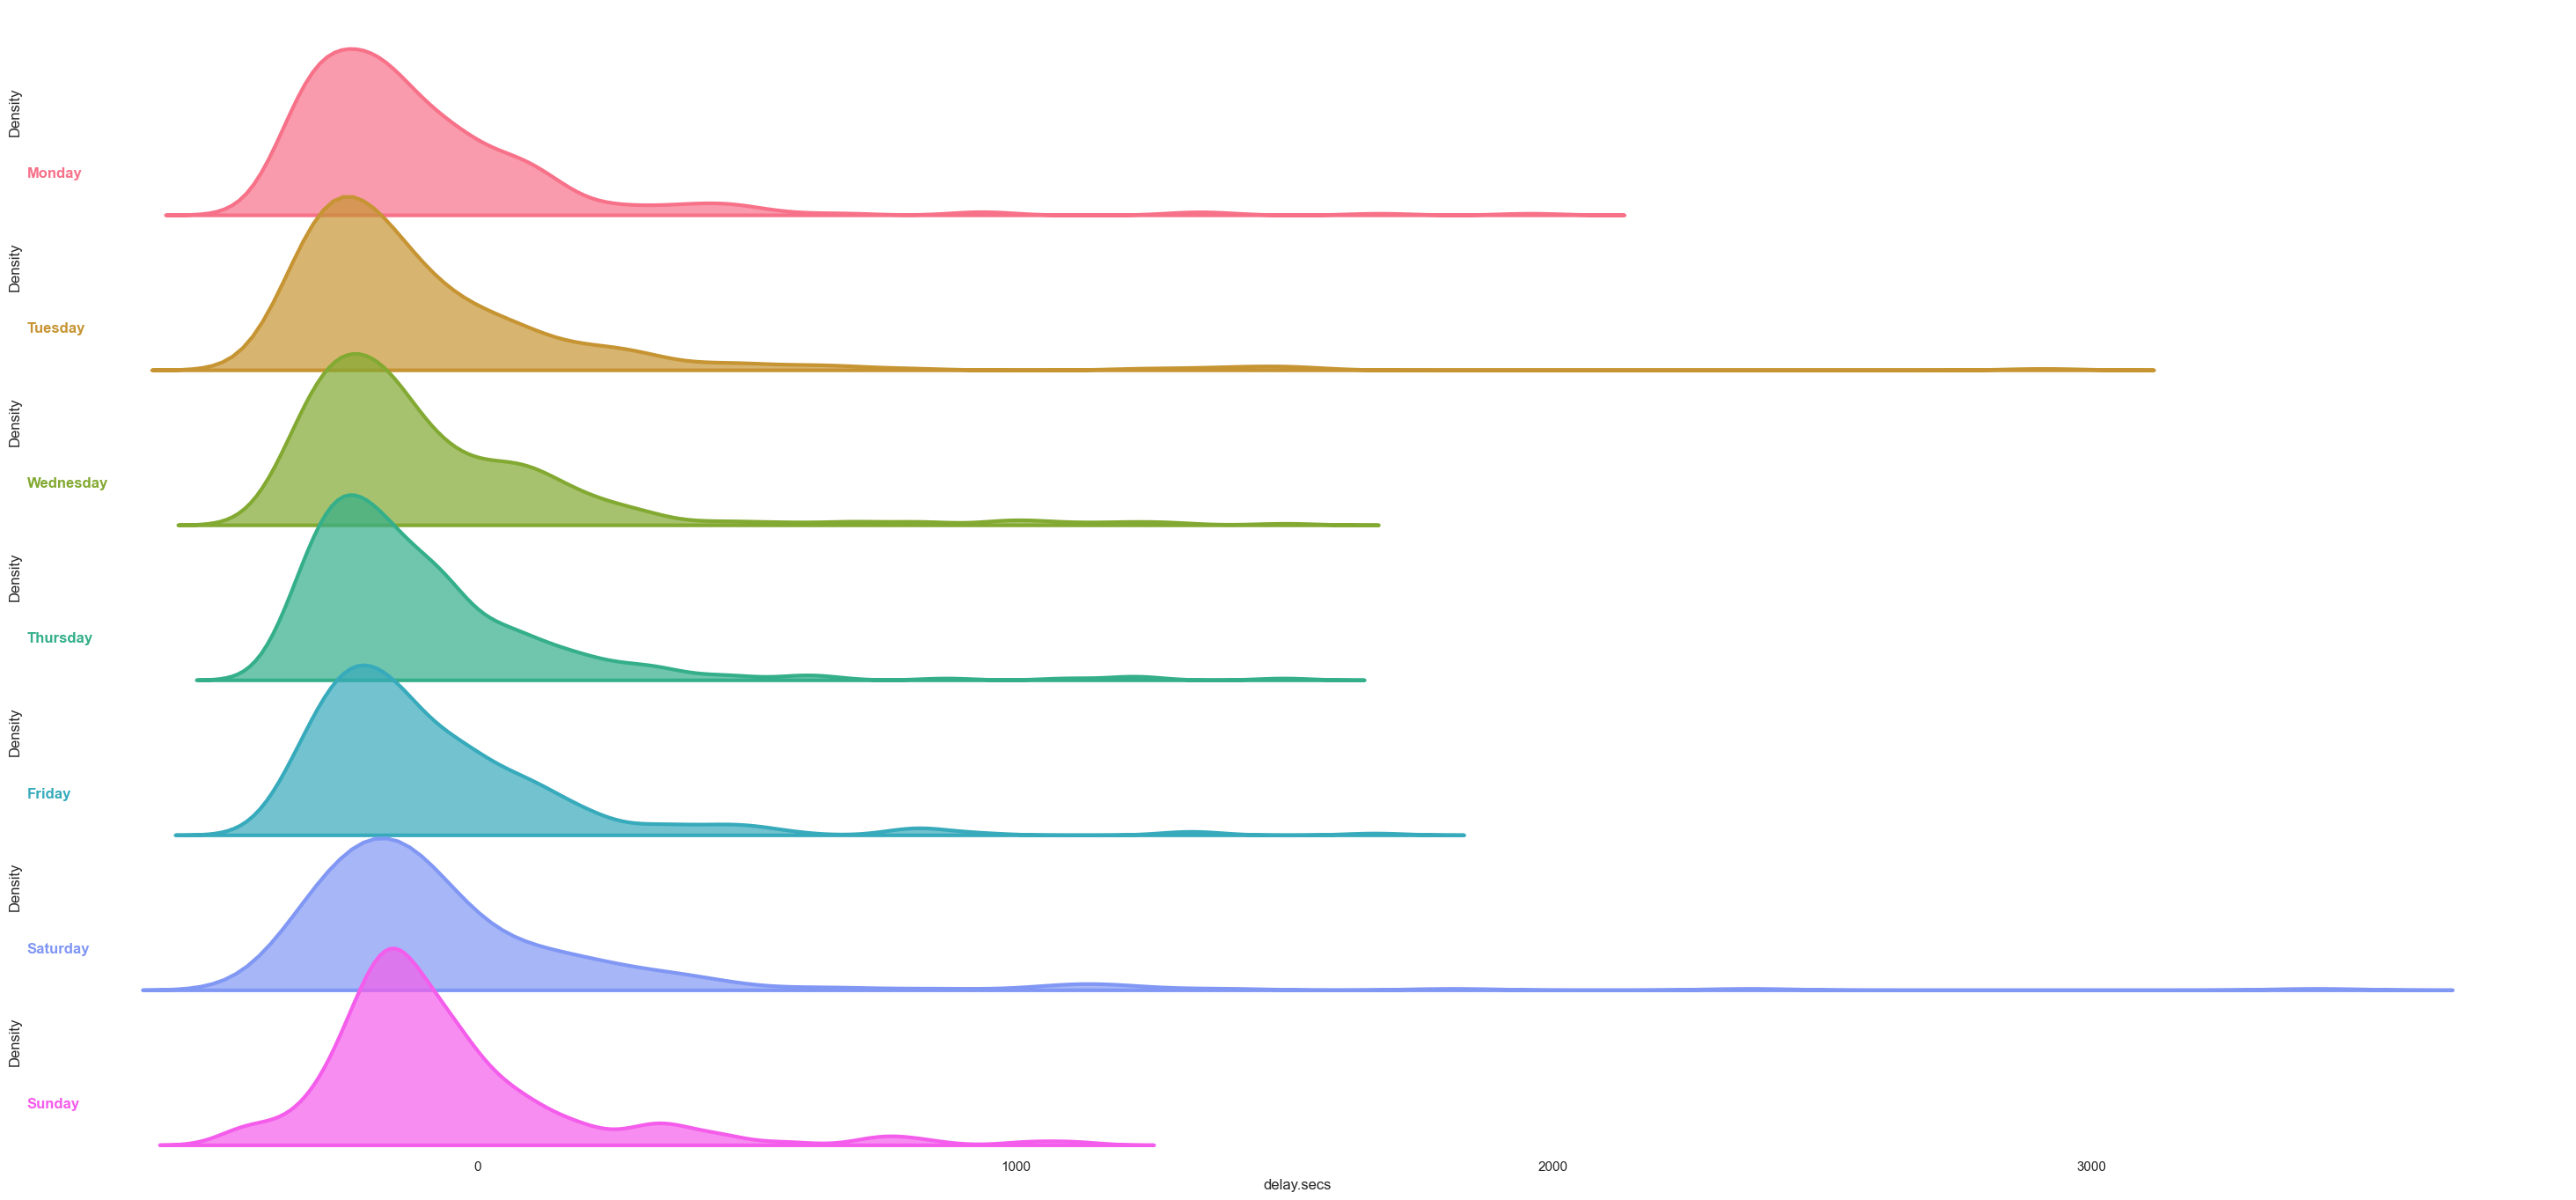

In [3]:
# 山脊图，根据周几来查看火车的延迟情况。
# 可以看出绝大部分情况下都是提前到的，但是在周二和周六下出现长时间延迟的可能会多一些，但也只是少数情况。
# 周日的演示情况反而会很少。可能是英国这边周日的车次会少很多，加上司机会想要早点回家。

# 定义周几的顺序
days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# 将'week.day'列转换为有序的类别类型
trainingDataConArr_df['week.day'] = pd.Categorical(trainingDataConArr_df['week.day'], categories=days_order, ordered=True)


# 使用seaborn的kdeplot来创建山脊图，首先我们需要设置图的风格
sns.set_theme(style="white",rc={"axes.facecolor":(0,0,0,0)})

# 创建一个画布
plt.figure(figsize=(100, 60))

# 创建一个颜色调色板
palette = sns.color_palette("husl", len(trainingDataConArr_df['week.day'].unique()))

# 使用FacetGrid和kdeplot绘制山脊图
g = sns.FacetGrid(trainingDataConArr_df, row='week.day', hue='week.day', aspect=15, height=2, palette=palette)

# 添加密度图，shade为True表示填充颜色
g.map(sns.kdeplot, 'delay.secs', clip_on=False, fill=True, alpha=0.7, lw=3, bw=.2)

# 使用白色分隔线增加每行之间的可读性
# g.map(plt.axhline, y=0, lw=2, clip_on=False)

# 定义和使用一个简单的函数来标签每个图的y轴
def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, fontweight="bold", color=color, ha="left", va="center", transform=ax.transAxes)

g.map(label, "delay.secs")

# 设置图的属性，移除y轴的标签，添加标题等
g.fig.subplots_adjust(hspace=-.250)
g.set_titles("")
g.set(yticks=[])
g.despine(bottom=True, left=True)

# 显示图表
plt.show()


In [4]:

# 统计 'train.code' 列中不同值的数量
# trainingDataConArr_df['train_code'].nunique()
# unique_train_codes_count_test = testDataConArr_df['train_code'].nunique()

# trainingDataTimings_df.columns#检查列名
# print(trainingDataTimings_df.columns)#检查列名
# congestion_df.columns
# print(trainingDataTimings_df.dtypes)#打印每列的数据类型



In [5]:
# #制作Scatterplot Matrix 散点图矩阵
# sns.set_theme(style="ticks")

# # trainingDataTimings_df = sns.load_dataset("penguins")
# sns.pairplot(trainingDataTimisngs_df, hue="day.week")

In [59]:
# 各种功能函数
#用于将一列的值转换为数值型特征的函数。
def encode_discrete_values(df, column_name):
    # 获取指定列的唯一值，并排序（如果是非数值型数据，将按字典序排序）
    unique_values = sorted(df[column_name].unique())
    
    # 生成从这些唯一值到 1~n 的映射字典
    value_to_num = {value: i + 1 for i, value in enumerate(unique_values)}
    
    # 检查列名是否在 DataFrame 中
    if column_name not in df.columns:
        print(f"Column '{column_name}' not found in DataFrame.")
        return None, None
    
    # 对指定列进行映射转换
    df[column_name + '_encoded'] = df[column_name].map(value_to_num)
    
    # 返回更新后的 DataFrame 和映射字典
    return df, value_to_num

# 使用示例
# df, mapping_dict = encode_discrete_values(df, 'your_column_name')

# 用于将周几转换为数值型
def encode_weekdays(df, column_name):
    # 定义星期几到数字的映射字典
    weekday_to_num = {
        'Monday': 1,
        'Tuesday': 2,
        'Wednesday': 3,
        'Thursday': 4,
        'Friday': 5,
        'Saturday': 6,
        'Sunday': 7,
    }
    
    # 检查列名是否在 DataFrame 中
    if column_name not in df.columns:
        print(f"Column '{column_name}' not found in DataFrame.")
        return None, None
    
    # 对指定列进行映射转换
    df[column_name + '_encoded'] = df[column_name].map(weekday_to_num)
    
    # 返回更新后的 DataFrame 和映射字典
    return df, weekday_to_num

# 你可以像这样调用这个函数：
# df, mapping_dict = encode_weekdays(df, 'your_column_name')
# 转换车站
def encode_common_discrete_values(df, columns):
    # 获取两列所有唯一值的并集，并排序
    # unique_values = sorted(set(df[columns[0]].unique()).union(set(df[columns[1]].unique())))
    value_to_num = {
        'LEEDS': 1,
        'NORMNTN':2,
        'WKFLDKG':3,
        'WKFLDWG':4,
        'BNSLY':5,
        'MEADWHL':6,
        'SHEFFLD':7,
    }
    # 生成映射字典
    # value_to_num = {value: i + 1 for i, value in enumerate(unique_values)}
    
    # 对指定的两列进行映射转换
    for column in columns:
        if column not in df.columns:
            print(f"Column '{column}' not found in DataFrame.")
            continue
        df[column + '_encoded'] = df[column].map(value_to_num)
    
    # 返回更新后的 DataFrame 和映射字典
    return df, value_to_num

# 使用示例
# df, mapping_dict = encode_common_discrete_values(df, ['column1_name', 'column2_name'])

# 计算时间差值
def calculate_time_difference(df, column1, column2, new_column_name='time_difference'):
    """
    Calculates the difference in seconds between two time columns in HH:MM:SS format and adds it as a new column.
    
    Args:
        df: The DataFrame containing the time columns.
        column1: The name of the first time column.
        column2: The name of the second time column.
        new_column_name: The name of the new column to add with the time difference (in seconds).
        
    Returns:
        The DataFrame with the added column showing the time difference in seconds.
    """
    
    # Ensure the columns exist in the DataFrame
    if column1 not in df.columns or column2 not in df.columns:
        raise ValueError(f"One or both of the specified columns '{column1}', '{column2}' do not exist in the DataFrame.")
    
    # Apply the text_to_seconds function to each time column
    seconds1 = df[column1].apply(text_to_seconds)
    seconds2 = df[column2].apply(text_to_seconds)
    
    # Calculate the difference and add it as a new column
    df[new_column_name] = (seconds1 - seconds2)#.abs()  # Use .abs() to ensure the difference is non-negative
    
    return df

# 使用示例
# 假设你有一个 DataFrame `df`，其中包含两列时间字符串 'start_time' 和 'end_time'
# df = calculate_time_difference(df, 'start_time', 'end_time', 'duration_seconds')

# 将两列相减
def subtract_columns(df, col1, col2, new_col_name):
    """
    Subtract values of one column from another column in a DataFrame and creates a new column with the results.

    Args:
    - df (pd.DataFrame): The input DataFrame.
    - col1 (str): The name of the first column (values to be subtracted from).
    - col2 (str): The name of the second column (values to subtract).
    - new_col_name (str): The name of the new column to store the result of the subtraction.

    Returns:
    - pd.DataFrame: A new DataFrame with the additional column containing the results of the subtraction.
    """
    df[new_col_name] = df[col1] - df[col2]
    return df

# Example usage:
# Assuming `df` is your DataFrame, 'Column_A' is the first column, 'Column_B' is the second column,
# and you want to store the result in a new column named 'Difference'.
# df = subtract_columns(df, 'Column_A', 'Column_B', 'Difference')
# Now `df` will include a new column named 'Difference' with the result of 'Column_A' - 'Column_B'.

#给所有等候站做减法
def subtract_columns_all(df, cols1, cols2, new_col_names):
    if not (len(cols1) == len(cols2) == len(new_col_names)):
        raise ValueError("The lists of columns and new column names must have the same length.")
    
    for col1, col2, new_col_name in zip(cols1, cols2, new_col_names):
        df[new_col_name] = df[col1] - df[col2]

    return df

#将两列取平均值
def add_average_column(df, col1, col2, new_col_name):
    """
    Adds a new column to the DataFrame with the average of two specified columns.

    Args:
    - df (pd.DataFrame): The input DataFrame.
    - col1 (str): The name of the first column to include in the average calculation.
    - col2 (str): The name of the second column to include in the average calculation.
    - new_col_name (str): The name of the new column that will contain the average values.

    Returns:
    - pd.DataFrame: The DataFrame with the additional column containing the average of the two specified columns.
    """
    df[new_col_name] = (df[col1] + df[col2]) / 2
    return df

# Example usage:
# Assuming `df` is your DataFrame, 'Column_A' and 'Column_B' are the columns you want to average,
# and 'Average' is the name of the new column you want to create.
# df = add_average_column(df, 'Column_A', 'Column_B', 'Average')
# Now `df` includes a new column named 'Average' with the average values of 'Column_A' and 'Column_B'.

#同时生成五列平均值
def add_average_columns(df, cols1, cols2, new_col_names):
    """
    Adds new columns to the DataFrame with the averages of pairs of specified columns.

    Args:
    - df (pd.DataFrame): The input DataFrame.
    - cols1 (list of str): The names of the first set of columns to include in the average calculations.
    - cols2 (list of str): The names of the second set of columns to include in the average calculations.
    - new_col_names (list of str): The names of the new columns that will contain the average values.

    Returns:
    - pd.DataFrame: The DataFrame with the additional columns containing the averages of the specified column pairs.
    """
    if not (len(cols1) == len(cols2) == len(new_col_names)):
        raise ValueError("The lists of columns and new column names must have the same length.")
    
    for col1, col2, new_col_name in zip(cols1, cols2, new_col_names):
        df[new_col_name] = (df[col1] + df[col2]) / 2

    return df

# Example usage:
# Assuming `df` is your DataFrame, and you have ten columns from which you want to create five new columns
# with their pairwise averages.
# cols1 = ['Column_A1', 'Column_B1', 'Column_C1', 'Column_D1', 'Column_E1']
# cols2 = ['Column_A2', 'Column_B2', 'Column_C2', 'Column_D2', 'Column_E2']
# new_col_names = ['Average_1', 'Average_2', 'Average_3', 'Average_4', 'Average_5']
# df = add_average_columns(df, cols1, cols2, new_col_names)
# Now `df` includes new columns named 'Average_1', 'Average_2', etc., with the averages of the specified column pairs.

# 查看所有车站组合 已经有别的函数实现这个功能了，可以不用
def count_onehot_combinations(df, columns):
    """
    Counts the unique combinations of values in one-hot encoded columns.

    Args:
    - df (pd.DataFrame): The input DataFrame.
    - columns (list of str): The names of the one-hot encoded columns to analyze.

    Returns:
    - int: The number of unique combinations found in the specified columns.
    """
    # Extract the specified columns from the DataFrame
    subset = df[columns]
    
    # Drop duplicate rows to find unique combinations
    unique_combinations = subset.drop_duplicates().reset_index(drop=True)
    
    # Return the number of unique combinations
    return unique_combinations

# Example usage:
# Assuming `df` is your DataFrame, and 'col1', 'col2', ... 'coln' are the one-hot encoded columns
# columns = ['col1', 'col2', 'coln']
# num_combinations = count_onehot_combinations(df, columns)
# print(f'There are {num_combinations} unique combinations in the specified columns.')

#统计车站组合，同时生成新的列，分类车站组合
def add_combination_column_and_get_combinations(df, columns):
    """
    Adds a new column to the DataFrame to represent the combination of one-hot encoded columns,
    and returns a DataFrame with unique combinations along with the modified original DataFrame.

    Args:
    - df (pd.DataFrame): The input DataFrame.
    - columns (list of str): The names of the one-hot encoded columns to analyze.

    Returns:
    - pd.DataFrame: The original DataFrame with an added column for the one-hot combination identifier.
    - pd.DataFrame: A DataFrame containing all unique combinations and their corresponding identifiers.
    """
    # Extract the specified columns from the DataFrame
    subset = df[columns]
    
    # Find unique combinations and reset index to use as unique identifier
    unique_combinations = subset.drop_duplicates().reset_index(drop=True).reset_index()
    unique_combinations.rename(columns={'index': 'combination_id'}, inplace=True)
    
    # Merge the unique identifiers back to the original DataFrame based on the one-hot columns
    df_combined = df.merge(unique_combinations, on=columns, how='left')
    
    # Return the modified original DataFrame and the unique combinations DataFrame
    return df_combined, unique_combinations

# Example usage:
# Assuming `df` is your DataFrame, and ['col1', 'col2', ...] are the one-hot encoded columns
# df_modified, unique_combinations_df = add_combination_column_and_get_combinations(df, ['col1', 'col2', ...])
# Now `df_modified` includes a new column 'combination_id' and `unique_combinations_df` includes all unique combinations.



#查看车站组合和车号是否有关联
def analyze_relationship(df, category_column, onehot_columns):
    """
    Analyzes the relationship between a categorical column and combinations of one-hot encoded columns.

    Args:
    - df (pd.DataFrame): The input DataFrame.
    - category_column (str): The name of the categorical column to analyze.
    - onehot_columns (list of str): The names of the one-hot encoded columns to analyze.

    Returns:
    - pd.DataFrame: A DataFrame summarizing the relationship between the categorical column and the one-hot combinations.
    """
    # Step 1: Create a unique identifier for each combination of one-hot encoded columns
    df['onehot_combination'] = df[onehot_columns].apply(lambda x: '_'.join(str(int(v)) for v in x), axis=1)
    
    # Step 2: Group by the categorical column and the onehot combination identifier, and count occurrences
    relationship_summary = df.groupby([category_column, 'onehot_combination']).size().reset_index(name='count')
    
    # Step 3: Sort the summary by the categorical column and count (optional)
    relationship_summary = relationship_summary.sort_values(by=[category_column, 'count'], ascending=[True, False])
    
    return relationship_summary

# Example usage:
# Assuming `df` is your DataFrame, 'category_col' is your categorical column, 
# and ['onehot_col1', 'onehot_col2', ...] are your one-hot encoded columns.
# relationship_df = analyze_relationship(df, 'category_col', ['onehot_col1', 'onehot_col2', ...])
# print(relationship_df)


# 生成统计表，可以看出车号和路线的关系
def analyze_relationship_with_combinations(df, category_column, onehot_columns):
    """
    Analyzes the relationship between a categorical column and combinations of one-hot encoded columns,
    and adds a column representing the categorical value of the one-hot combinations.

    Args:
    - df (pd.DataFrame): The input DataFrame.
    - category_column (str): The name of the categorical column to analyze.
    - onehot_columns (list of str): The names of the one-hot encoded columns to analyze.

    Returns:
    - pd.DataFrame: A DataFrame with unique one-hot combinations and their corresponding category counts.
    """
    # Step 1: Find unique combinations and assign a unique identifier
    unique_combinations = df[onehot_columns].drop_duplicates().reset_index(drop=True)
    unique_combinations['combination_id'] = range(len(unique_combinations))
    # print(unique_combinations)

    # Step 2: Add the combination identifier to the original DataFrame # 现在不再需要了，因为已经在原df里加入这一列
    # df = df.merge(unique_combinations[:,-'combination_id'], on=onehot_columns, how='left')
    
    # Step 3: Group by the categorical column and the combination identifier, and count occurrences
    relationship_summary = df.groupby([category_column, 'combination_id']).size().reset_index(name='count')
    # print(relationship_summary)
    # Step 4: Merge the summary with unique combinations to add the one-hot encoded representation
    relationship_summary = relationship_summary.merge(unique_combinations, on='combination_id', how='left')
    
    # Optional: Sort the summary by the categorical column and count
    relationship_summary = relationship_summary.sort_values(by=[category_column, 'count'], ascending=[True, False])
    
    return relationship_summary

# Example usage
# relationship_summary = analyze_relationship_with_combinations(df, 'category_column', ['onehot_col1', 'onehot_col2', ...])
# print(relationship_summary)

#查看列名，但是每次换行
def print_column_names_new_line(df):
    """
    Prints each column name of the DataFrame on a new line.

    Args:
    df (pd.DataFrame): The DataFrame whose column names are to be printed.
    """
    # 遍历列名并打印每个列名
    for column in df.columns:
        print(f'\'{column}\',')

# print_column_names_new_line(trainmatrix)

#PCA方法
def pca_reduce_dimension(df, target_column=None, variance_threshold=0.95):
    """
    Performs PCA on the given DataFrame to reduce its dimensionality,
    preserving the specified amount of variance.

    Args:
    df (pd.DataFrame): The input DataFrame.
    target_column (str, optional): The name of the target variable column. If provided, this column will be excluded from PCA.
    variance_threshold (float, optional): The percentage of variance to preserve in the PCA transformation. Default is 0.95.

    Returns:
    pd.DataFrame: A DataFrame transformed by PCA, with dimensionality reduced.
    """
    # If a target column is specified, exclude it from the PCA transformation
    if target_column:
        features = df.drop(target_column, axis=1)
        target = df[target_column]
    else:
        features = df
    
    # Standardizing the features
    features_standardized = StandardScaler().fit_transform(features)
    
    # Performing PCA
    pca = PCA(n_components=variance_threshold)
    principal_components = pca.fit_transform(features_standardized)
    
    # Creating a DataFrame with the principal components
    columns = [f'Principal Component {i+1}' for i in range(principal_components.shape[1])]
    df_pca = pd.DataFrame(data=principal_components, columns=columns)
    
    # If a target column was specified, add it back to the DataFrame
    if target_column:
        df_pca[target_column] = target.reset_index(drop=True)
    
    return df_pca

# Example usage
# Assuming 'df' is your DataFrame and 'target' is the name of your target column.
# pca_df = pca_reduce_dimension(df, target_column='target')
# print(pca_df.head())



In [7]:
#对于小站的处理：先使用0和1代表是否经过这一站（存在性编码），然后使用平均值代表这些站的总平均延误（聚合）
# 还是之前的问题，我需要在处理数据的前后都进行数据分析
def datapreprcession(targetdatatimings = trainingDataTimings_df,dataconarr= trainingDataConArr_df,historicalcon=congestion_df):
    #等后续把之前写的内容全部放到这里来
    #先先出第一列多出来的unmaned列
    matrixdata =drop_first_column(targetdatatimings)
    dataconarr = drop_first_column(dataconarr)
    historicalcon = drop_first_column(historicalcon)
    #重置index列
    dataconarr = dataconarr.reset_index()
    #合并表格
    matrixdata = matrixdata.merge(dataconarr, left_on='id', right_on='index', how='left').drop('index',axis=1)
    #合并历史延误
    matrixdata = matrixdata.merge(historicalcon,left_on=['week.day', 'hour'],right_on=['Day','Hour'],how='left')
    #删除一列重复的列
    matrixdata = matrixdata.drop(['day.week','week.day','hour','train_code','arrival.to_y'],axis=1)
    # 将一列的值转换为数值型特征
    matrixdata, traincode_to_num = encode_discrete_values(matrixdata,column_name='train.code')
    # print(traincode_to_num)
    # 按顺序转换周几为数值型特征
    matrixdata, day_to_num = encode_weekdays(matrixdata,column_name='Day')
    # 将车站转换为数值型特征
    matrixdata,station_to_num=encode_common_discrete_values(matrixdata,['departure.from','arrival.to_x'])
    # print(station_to_num)
    # 计算时间差值
    matrixdata = calculate_time_difference(matrixdata,column1='departure.time',column2='departure.schedule',new_column_name='departure.delay')
    matrixdata = calculate_time_difference(matrixdata,column1='arrival.time_x',column2='arrival.schedule_x',new_column_name='arrival.delay')
    return matrixdata
#应用预处理，得到目标可以训练的数据
# trainmatrix = datapreprcession(targetdatatimings=trainingDataTimings_df,dataconarr=trainingDataConArr_df,historicalcon=congestion_df)
# testmatrix = datapreprcession(targetdatatimings=testDataTimings_df,dataconarr=testDataConArr_df,historicalcon=congestion_df)



In [8]:
# print(trainmatrix['departure.from'].unique())
# print(trainmatrix['arrival.to_x'].unique())
# print(trainmatrix.columns)
# print(trainmatrix.head(10))
# trainmatrix.to_csv('trainmatrix.csv',index=False)

In [19]:
#做图函数
#制作数值型列的山脊图
'''
def plot_ridge(df, selected_columns):
    """
    Plots a ridge plot for selected columns of a DataFrame.

    Args:
    - df (pd.DataFrame): The DataFrame containing the data.
    - selected_columns (list of str): List of column names to plot the ridge plot for.
    """
    # Ensure that selected_columns is a list
    if not isinstance(selected_columns, list):
        raise ValueError("selected_columns must be a list of column names.")
    
    # Melt the dataframe to long format for selected columns
    melted_df = df[selected_columns].melt(var_name='Variable', value_name='Value')

    # Set up the FacetGrid
    g = sns.FacetGrid(melted_df, row='Variable', hue='Variable', aspect=15, height=0.5, palette="tab20")

    # Map the densities to the FacetGrid
    g.map(sns.kdeplot, 'Value', bw_adjust=0.5, clip_on=False, fill=True, alpha=1, linewidth=1.5)
    g.map(sns.kdeplot, 'Value', clip_on=False, color="w", lw=2, bw_adjust=0.5)
    
    # Overlap each row
    g.fig.subplots_adjust(hspace=-0.3)

    # Remove axes details that don't play well with overlap
    g.set_titles("")
    g.set(yticks=[])
    g.despine(bottom=True, left=True)
    g.fig.suptitle('Ridge Plot of Selected Variables')
    plt.subplots_adjust(top=0.95)

# Example usage:
# Assuming `restructured_data` is your DataFrame
# selected_columns = ['column1', 'column2']  # Replace with your actual column names
# plot_ridge(restructured_data, selected_columns)
'''

#制作二元变量列的柱状统计图，未使用
def plot_bar_for_binary_columns(df, target_columns):
    """
    This function plots bar plots for given binary columns in a DataFrame.

    Args:
    - df (pd.DataFrame): The DataFrame containing the data.
    - target_columns (list of str): List of binary column names to be plotted.
    """
    # 设置绘图风格
    sns.set_style("whitegrid")
    
    # 确定子图的布局
    num_cols = len(target_columns)
    if num_cols == 1:
        fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(6, 4))
        axes = [axes]
    else:
        fig, axes = plt.subplots(nrows=num_cols, ncols=1, figsize=(6, 4 * num_cols))
    
    for i, col in enumerate(target_columns):
        # 计算每个类别的计数
        count_data = df[col].value_counts().sort_index()
        # 绘制柱状图
        sns.barplot(x=count_data.index, y=count_data.values, ax=axes[i], palette="viridis")
        axes[i].set_title(f'Distribution of {col}')
        axes[i].set_ylabel('Count')
        axes[i].set_xlabel(col)
    
    plt.tight_layout()
    plt.show()

# 示例使用方法
# 假设 df 是你的 DataFrame，'binary_col1' 和 'binary_col2' 是二元变量列名
# plot_bar_for_binary_columns(df, ['binary_col1', 'binary_col2'])

#二元变量列，带上他们的统计个数
def plot_bar_for_binary_columns_with_counts(df, target_columns):
    """
    This function plots bar plots for given binary columns in a DataFrame and
    annotates each bar with its count.

    Args:
    - df (pd.DataFrame): The DataFrame containing the data.
    - target_columns (list of str): List of binary column names to be plotted.
    """
    # 设置绘图风格
    sns.set_style("whitegrid")
    
    # 确定子图的布局
    num_cols = len(target_columns)
    if num_cols == 1:
        fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(6, 4))
        axes = [axes]
    else:
        fig, axes = plt.subplots(nrows=num_cols, ncols=1, figsize=(6, 4 * num_cols))
    
    for i, col in enumerate(target_columns):
        # 计算每个类别的计数
        count_data = df[col].value_counts().sort_index()
        # 绘制柱状图
        ax = sns.barplot(x=count_data.index, y=count_data.values, ax=axes[i], palette="viridis")
        axes[i].set_title(f'Distribution of {col}')
        axes[i].set_ylabel('Count')
        axes[i].set_xlabel(col)

        # 在柱子上方显示计数
        for p in ax.patches:
            ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                        ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
                        textcoords='offset points')

    plt.tight_layout()
    plt.show()

# 示例使用方法
# 假设 df 是你的 DataFrame，'binary_col1' 和 'binary_col2' 是二元变量列名
# plot_bar_for_binary_columns_with_counts(df, ['binary_col1', 'binary_col2'])


#分类列和目标列的分布关系 小提琴图
def plot_violin_by_group(df, group_column, target_column):

    plt.figure(figsize=(10, 6))
    sns.violinplot(x=group_column, y=target_column, data=df)
    plt.title(f'Distribution of {target_column} by {group_column}')
    plt.xlabel(group_column)
    plt.ylabel(target_column)
    plt.show()
# plot_violin_by_group(df, 'Group', 'Value')


# 分类列和目标列的分布关系 密度图
def plot_density_by_group(df, group_column, target_column):
    """
    Plots density plots of a target column distribution within each group defined by another column.

    Args:
    - df (pd.DataFrame): The input DataFrame.
    - group_column (str): The name of the column to group by.
    - target_column (str): The name of the column for which to plot the density distribution.
    """
    plt.figure(figsize=(10, 6))
    
    # 为每个分组绘制密度图
    unique_groups = df[group_column].unique()
    for group in unique_groups:
        subset = df[df[group_column] == group]
        sns.kdeplot(subset[target_column], label=f'{group}', shade=True)
    
    plt.title(f'Density Distribution of {target_column} by {group_column}')
    plt.xlabel(target_column)
    plt.ylabel('Density')
    plt.legend(title=group_column)
    plt.show()

# plot_density_by_group(df, 'Group', 'Value')
#分类列和目标列的分布关系 柱状
def plot_histograms_by_group(df, group_column, value_column):
    """
    Plots histograms of a value column within each group defined by the group column.

    Args:
    - df (pd.DataFrame): The DataFrame containing the data.
    - group_column (str): The name of the column used to define groups.
    - value_column (str): The name of the column for which to plot the histograms.
    """
    unique_groups = df[group_column].unique()
    
    # Determine the number of unique groups to set up the subplot dimensions
    n_groups = len(unique_groups)
    n_rows = (n_groups // 2) + (n_groups % 2)
    
    fig, axes = plt.subplots(nrows=n_rows, ncols=2, figsize=(12, 6 * n_rows), constrained_layout=True)
    
    # Flatten axes array if more than one row
    if n_groups > 2:
        axes = axes.flatten()
    else:
        axes = axes.reshape(-1)  # Ensure axes is always an array for consistency
    
    # Loop through the groups and plot histograms
    for i, group in enumerate(unique_groups):
        ax = axes[i]
        subset = df[df[group_column] == group][value_column]
        sns.histplot(subset, ax=ax, kde=False, binwidth=20)#binwidth 调整柱子宽度 或者bin设置多少个柱子
        ax.set_title(f'{value_column} distribution in {group}')
        ax.set_xlabel(value_column)
        ax.set_ylabel('Frequency')
    
    # If the number of plots is odd, hide the last ax
    if n_groups % 2 != 0:
        axes[-1].axis('off')

    plt.show()

# plot_histograms_by_group(df, 'group_column', 'value_column')

#绘制delayNotts的柱状分布
def plot_bar_for_one_var(df,col):
    # 设置绘图风格
    sns.set_style("whitegrid")

    # 绘制柱状分布图（直方图）
    plt.figure(figsize=(10, 6))  # 设置图形的大小
    sns.histplot(df[col], bins=50, kde=False, color='skyblue')  # bins指定直方图的柱数，kde为是否绘制核密度估计

    plt.title(f'Distribution of {col}')  # 设置图形标题
    plt.xlabel('Delay (Notts)')  # 设置x轴标签
    plt.ylabel('Frequency')  # 设置y轴标签
    plt.show()
    return 0
# plot_bar_for_one_var(trainingDataConArr_df,'delay.secs')

#根据分类列观察目标变量分布，箱线图或者小提琴图
def plot_distribution(data, category_col, target_col, plot_type="boxplot"):
    """
    绘制目标变量在不同分类下的分布图。

    参数:
    - data: pandas DataFrame, 包含数据的DataFrame。
    - category_col: str, 分类列的名称。
    - target_col: str, 目标变量列的名称。
    - plot_type: str, 图的类型，"boxplot" 或 "violinplot"。
    """
    plt.figure(figsize=(10, 6))  # 设置图形的大小
    if plot_type == "boxplot":
        sns.boxplot(x=category_col, y=target_col, data=data)
    elif plot_type == "violinplot":
        sns.violinplot(x=category_col, y=target_col, data=data)
    else:
        raise ValueError("plot_type must be 'boxplot' or 'violinplot'")
    
    plt.title(f'Distribution of {target_col} by {category_col}')  # 设置标题
    plt.xticks(rotation=45)  # 旋转x轴标签，以便更容易阅读
    plt.show()

# 示例使用
# 假设有一个名为df的DataFrame，其中包含分类列'Category'和目标变量'Target'
# plot_distribution(df, 'Category', 'Target', 'boxplot')

# 画热力图，准确来说是层次聚合热力图
def plot_heatmap(df, cols):
    """
    Plots a heatmap for the correlation matrix of the specified columns in the DataFrame.

    Args:
    df (pandas.DataFrame): The DataFrame to analyze.
    cols (list of str): List of column names to include in the heatmap.

    Returns:
    None
    """
    # Calculate the correlation matrix
    corr = df[cols].corr()

    #使用0填充nan，这样才能使用clustermap
    corr_filled = corr.fillna(0)
    # Set up the matplotlib figure
    # f, ax = plt.subplots(figsize=(9, 6))

    # # Draw the heatmap with the mask and correct aspect ratio
    # sns.heatmap(corr, annot=False, ax=ax, cmap='coolwarm', fmt='.2f',
    #             linewidths=.5, cbar_kws={"shrink": .5})#annot 用于控制是否显示数字在每个格子上
    sns.clustermap(corr_filled, cmap='coolwarm', linewidths=.5, annot=False,figsize=(9, 6))

    plt.show()

# Example of usage:
# plot_heatmap(your_dataframe, ['col1', 'col2', 'col3', 'col4'])
    
#画pairplot,生成起来很耗费时间
def generate_pairplot(df, columns):
    """
    Generates a pairplot for the specified columns in the DataFrame.

    Args:
    df (pandas.DataFrame): The DataFrame to analyze.
    columns (list of str): List of column names to include in the pairplot.

    Returns:
    None: Displays the pairplot.
    """
    # Use seaborn's pairplot function to plot pairwise relationships
    sns.pairplot(df[columns])

    # Show the plot
    plt.show()

# Example usage:
# Assuming `df` is your DataFrame, and you want to generate a pairplot for 'Column1', 'Column2', and 'Column3'.
# generate_pairplot(df, ['Column1', 'Column2', 'Column3'])
    
#一个分类列，多个数值列，生成小提琴图
def plot_violin_by_category(df, category_column, value_columns):
    """
    Generates violin plots for multiple numeric columns grouped by a categorical column.

    Args:
    df (pandas.DataFrame): The DataFrame containing the data.
    category_column (str): The name of the categorical column to group the data by.
    value_columns (list of str): List of numeric column names to generate violin plots for.

    Returns:
    None: Displays the violin plots.
    """
    # Setting the overall figure size
    plt.figure(figsize=(12, len(value_columns) * 4))
    
    # Plotting a violin plot for each numeric column grouped by the categorical column
    for i, value_column in enumerate(value_columns, start=1):
        plt.subplot(len(value_columns), 1, i)
        sns.violinplot(x=category_column, y=value_column, data=df)
        plt.title(f'Violin plot of {value_column} by {category_column}')
    
    plt.tight_layout()
    plt.show()

# Example usage:
# Assuming `df` is your DataFrame, 'CategoryColumn' is your categorical column, 
# and ['NumericColumn1', 'NumericColumn2'] are your numeric columns.
# plot_violin_by_category(df, 'CategoryColumn', ['NumericColumn1', 'NumericColumn2'])




In [57]:
# 考虑到最好还是一行代表一个数据点，关键分只在于不能将conarr表扩散到matrixdata里
'''
def rebuild_matrixdata(df):

    # 这是车站与其对应顺序的映射字典
    stations_order = {
        'LEEDS': 1,
        'NORMNTN': 2,
        'WKFLDKG': 3,
        'WKFLDWG': 4,  # 注意这个站名出现了两次，我会假设第二个应为唯一的
        'BNSLY': 5,
        'MEADWHL': 6,
        'SHEFFLD': 7,
        # 'WKFLDWG': 8,  # 重复的站点，已注释
    }

    # 假设df是原始的DataFrame
    # 确保你已经加载了原始的DataFrame
    # df = pd.read_csv('/path/to/csv')

    # 创建一个空的DataFrame，用于存储重构后的数据
    restructured_data = pd.DataFrame()

    # 遍历每个ID，并构建重构后的数据
    for id_val, group in df.groupby('id'):
        new_row = {}
        # 标记每个车站的出现
        station_presence = {station: 0 for station in stations_order}
        # 遍历每个车站，检查它是否在每个ID的路线上
        for station in stations_order:
            # 初始化时间和计划列
            new_row[f"{station}_time"] = None
            new_row[f"{station}_schedule"] = None
            # 检查出发点
            dep_rows = group[group['departure.from'] == station]
            if not dep_rows.empty:
                # 设置存在性编码
                station_presence[station] = 1
                # 获取时间和计划
                new_row[f"{station}_time"] = dep_rows['departure.time'].iloc[0]
                new_row[f"{station}_schedule"] = dep_rows['departure.schedule'].iloc[0]
            # 检查到达点
            arr_rows = group[group['arrival.to'] == station]
            if not arr_rows.empty:
                # 设置存在性编码
                station_presence[station] = 1
                # 如果出发时间已经设置了，那么我们更新为到达时间
                if pd.isna(new_row[f"{station}_time"]):
                    new_row[f"{station}_time"] = arr_rows['arrival.time'].iloc[0]
                # 同理更新计划时间
                if pd.isna(new_row[f"{station}_schedule"]):
                    new_row[f"{station}_schedule"] = arr_rows['arrival.schedule'].iloc[0]
        # 合并存在性编码
        new_row = {**new_row, **station_presence}
        # 将新行添加到重构数据中
        # restructured_data = restructured_data.append(new_row, ignore_index=True)
        restructured_data = pd.concat([restructured_data, pd.DataFrame([new_row])], ignore_index=True)


    # 设置新的列顺序，包括时间、计划和存在性编码
    columns_order = []
    for station in stations_order:
        columns_order.extend([f"{station}_time", f"{station}_schedule", f"{station}_presence"])

    restructured_data = restructured_data[columns_order]
    restructured_data['id'] = restructured_data.index  # 添加ID列

    # 显示结果
    print(restructured_data.head())

    # 保存到新的 CSV 文件中
    # restructured_data.to_csv('restructured_data.csv', index=False)

    return restructured_data
'''

'''
def rebuild_matrixdata(df):
    # Station order mapping
    stations_order = {
        'LEEDS': 1,
        'NORMNTN': 2,
        'WKFLDKG': 3,
        'WKFLDWG': 4,  # Assuming this is a unique station
        'BNSLY': 5,
        'MEADWHL': 6,
        'SHEFFLD': 7
    }
    
    rows_list = []  # This list will accumulate all the rows before adding them to DataFrame
    
    # Process each train ID
    for train_id in df['id'].unique():
        train_data = df[df['id'] == train_id]
        row_data = {f"{station}_{suffix}": None for station in stations_order for suffix in ['time', 'schedule']}
        row_data.update({f"{station}_presence": 0 for station in stations_order})
        
        for station in stations_order:
            # Check departure information
            if station in train_data['departure.from'].values:
                row = train_data[train_data['departure.from'] == station].iloc[0]
                row_data[f"{station}_time"] = row['departure.time']
                row_data[f"{station}_schedule"] = row['departure.schedule']
                row_data[f"{station}_presence"] = 1
            
            # Check arrival information
            if station in train_data['arrival.to'].values:
                row = train_data[train_data['arrival.to'] == station].iloc[0]
                row_data[f"{station}_time"] = row_data[f"{station}_time"] or row['arrival.time']
                row_data[f"{station}_schedule"] = row_data[f"{station}_schedule"] or row['arrival.schedule']
                row_data[f"{station}_presence"] = 1
        
        rows_list.append(row_data)
    
    # Convert the list of dictionaries to a DataFrame
    restructured_data = pd.DataFrame(rows_list)
    
    # Set the train ID as the index of the new DataFrame
    restructured_data['id'] = df['id'].unique()
    restructured_data.set_index('id', inplace=True)
    
    return restructured_data
'''

def rebuild_matrixdata(df):
    stations_order = [
        'LEEDS', 'NORMNTN', 'WKFLDKG', 'WKFLDWG', 'BNSLY', 'MEADWHL', 'SHEFFLD'
    ]
    
    # 准备新的DataFrame结构
    new_columns = []
    for station in stations_order:
        if station not in ['LEEDS', 'SHEFFLD']:  # 对于LEEDS和SHEFFLD不需要存在性编码
            new_columns.append(f"{station}_presence")
        new_columns.extend([
            f"{station}_dep_time", f"{station}_dep_schedule",
            f"{station}_arr_time", f"{station}_arr_schedule"
        ])
        
    restructured_data_list = []

    for train_id in df['id'].unique():
        train_data = df[df['id'] == train_id]
        row_data = {col: None for col in new_columns}
        
        for station in stations_order:
            # 处理存在性编码
            if station not in ['LEEDS', 'SHEFFLD']:
                row_data[f"{station}_presence"] = int(station in train_data['departure.from'].values or station in train_data['arrival.to'].values)
            
            # 处理出发时间和计划
            dep_station_data = train_data[train_data['departure.from'] == station]
            if not dep_station_data.empty:
                row_data[f"{station}_dep_time"] = dep_station_data.iloc[0]['departure.time']
                row_data[f"{station}_dep_schedule"] = dep_station_data.iloc[0]['departure.schedule']
            
            # 处理到达时间和计划
            arr_station_data = train_data[train_data['arrival.to'] == station]
            if not arr_station_data.empty:
                row_data[f"{station}_arr_time"] = arr_station_data.iloc[0]['arrival.time']
                row_data[f"{station}_arr_schedule"] = arr_station_data.iloc[0]['arrival.schedule']
                
        restructured_data_list.append(row_data)
    
    restructured_data = pd.DataFrame(restructured_data_list)
    restructured_data['id'] = df['id'].unique()
    restructured_data.set_index('id', inplace=True)

    #鉴于后续统一操作，这drop建议之后再用
    # restructured_data = restructured_data.drop(['LEEDS_arr_time','LEEDS_arr_schedule','SHEFFLD_dep_time','SHEFFLD_dep_schedule'],axis=1)
    
    return restructured_data

# 用于将rebuild后的车站情况使用读秒函数将其变为秒
def calculate_delays_and_stays(df):
    # 遍历DataFrame的每一行
    for index, row in df.iterrows():
        for col in df.columns:
            if '_dep_time' in col or '_arr_time' in col:
                station = col.split('_')[0]
                time_type = 'dep' if 'dep' in col else 'arr'  # 确定是出发时间还是到达时间

                # 构造时间和计划时间的列名
                actual_col = f'{station}_{time_type}_time'
                schedule_col = f'{station}_{time_type}_schedule'
                
                # 计算延误时间
                if pd.notna(row[actual_col]) and pd.notna(row[schedule_col]):
                    actual_seconds = text_to_seconds(row[actual_col])
                    schedule_seconds = text_to_seconds(row[schedule_col])
                    df.at[index, f'{station}_{time_type}_delay'] = actual_seconds - schedule_seconds

            # 对于中间站，计算停留时间和计划停留时间
            if '_dep_time' in col and station != 'LEEDS' and station != 'SHEFFLD':
                arr_col = f'{station}_arr_time'
                dep_col = f'{station}_dep_time'
                arr_schedule_col = f'{station}_arr_schedule'
                dep_schedule_col = f'{station}_dep_schedule'

                # 计算实际停留时间和计划停留时间，假设时间和计划时间都存在
                if pd.notna(row[arr_col]) and pd.notna(row[dep_col]) and pd.notna(row[arr_schedule_col]) and pd.notna(row[dep_schedule_col]):
                    arr_seconds = text_to_seconds(row[arr_col])
                    dep_seconds = text_to_seconds(row[dep_col])
                    arr_schedule_seconds = text_to_seconds(row[arr_schedule_col])
                    dep_schedule_seconds = text_to_seconds(row[dep_schedule_col])
                    
                    df.at[index, f'{station}_stay'] = dep_seconds - arr_seconds
                    df.at[index, f'{station}_scheduled_stay'] = dep_schedule_seconds - arr_schedule_seconds

    return df


# 输出所有数值型列的小提琴图
def plot_violin_for_numerical_columns(df):
    """
    This function takes a DataFrame and plots violin plots for all numerical columns.

    Args:
    - df (pd.DataFrame): The DataFrame containing the data.

    Output:
    - Displays violin plots for each numerical column in the DataFrame.
    """
    # Determine numerical columns by dtype
    numerical_cols = df.select_dtypes(include=['float64', 'int64']).columns

    # Set up the matplotlib figure (adjust figsize as needed)
    fig, axes = plt.subplots(nrows=len(numerical_cols), ncols=1, figsize=(8, len(numerical_cols) * 4))
    
    # If only one numerical column, axes might not be an array, so we ensure it's always treated as one
    if len(numerical_cols) == 1:
        axes = [axes]
    
    # Plot violin plot for each numerical column
    for i, col in enumerate(numerical_cols):
        sns.violinplot(x=df[col], ax=axes[i],fill= False)
        axes[i].set_title(col)
        axes[i].set_ylabel('Density')
    
    plt.tight_layout()
    plt.show()

# Assuming `restructured_data` is the DataFrame you want to use
# plot_violin_for_numerical_columns(restructured_data)

#数值型小提琴图，合成一张图
"""
def plot_violin_all_numerical_in_one(df):
    '''
    This function takes a DataFrame, melts it to long format for all numerical columns,
    and then plots violin plots for these columns all in one figure.

    Args:
    - df (pd.DataFrame): The DataFrame containing the data.

    Output:
    - A single figure with violin plots for each numerical column.
    '''
    # Select only numerical columns
    numerical_df = df.select_dtypes(include=['float64', 'int64'])

    # Melt the DataFrame
    melted_df = numerical_df.melt(value_vars=numerical_df.columns)

    # Plot
    plt.figure(figsize=(10, 6))
    sns.violinplot(x='variable', y='value', data=melted_df)
    plt.xticks(rotation=45)  # Rotate the x labels for better readability
    plt.xlabel('Variables')
    plt.ylabel('Values')
    plt.title('Violin plot for all numerical columns')
    plt.tight_layout()  # Adjust layout to not overlap
    plt.show()

# Assuming `restructured_data` is your DataFrame:
# plot_violin_all_numerical_in_one(restructured_data) 
"""

#基于rebuild_matrixdata函数的新预处理步骤
def datapreprcession2(targetdatatimings = trainingDataTimings_df,dataconarr= trainingDataConArr_df,historicalcon=congestion_df):
    #等后续把之前写的内容全部放到这里来
    #先先出第一列多出来的unmaned列
    datatimings =drop_first_column(targetdatatimings)
    # print(datatimings.head())
    dataconarr = drop_first_column(dataconarr)
    historicalcon = drop_first_column(historicalcon)
    #重置index列
    dataconarr = dataconarr.reset_index()

    #关键两步
    # 重建特征集，每一行代表一辆火车
    matrixdata =rebuild_matrixdata(datatimings)
    #统计delay和stay等特征工程
    matrixdata = calculate_delays_and_stays(matrixdata)

    #合并表格
    matrixdata = matrixdata.merge(dataconarr, left_on='id', right_on='index', how='left').drop('index',axis=1)
    #合并历史延误
    matrixdata = matrixdata.merge(historicalcon,left_on=['week.day', 'hour'],right_on=['Day','Hour'],how='left')
    #删除重复的几列,不删除也可以，等到最后直接从其中提取
    matrixdata = matrixdata.drop(['week.day','hour'],axis=1)
    # 将train.code转换为数值型特征
    # matrixdata, traincode_to_num = encode_discrete_values(matrixdata,column_name='train_code')
    # 另一种将train.code转换为数值型特征的办法：uniques是唯一真值对照表
    codes, uniques = pd.factorize(matrixdata['train_code'])
    matrixdata['train_code.code'] = codes
    #将Day也转换为数值型特征
    days, uniques2 = pd.factorize(matrixdata['Day'])
    matrixdata['Day.code'] = days
    # 将周几转换为onehot特征
    matrixdata = pd.get_dummies(matrixdata, columns=['Day'])
    #将congestion的值取一个平均
    matrixdata = add_average_columns(matrixdata,
                                     cols1=['Leeds.trains_x', 'Leeds.av.delay_x',
       'Sheffield.trains_x', 'Sheffield.av.delay_x', 'Nottingham.trains_x',
       'Nottingham.av.delay_x'],
       cols2=['Leeds.trains_y', 'Leeds.av.delay_y', 'Sheffield.trains_y',
       'Sheffield.av.delay_y', 'Nottingham.trains_y', 'Nottingham.av.delay_y'],
       new_col_names=['Leeds.trains', 'Leeds.av.delay',
       'Sheffield.trains', 'Sheffield.av.delay', 'Nottingham.trains',
       'Nottingham.av.delay'])
    # 统计小站组合，并生成分类列
    matrixdata, unique_combinations = add_combination_column_and_get_combinations(matrixdata,['NORMNTN_presence','WKFLDKG_presence','WKFLDWG_presence','BNSLY_presence','MEADWHL_presence'])
    # print(unique_combinations)
    #将小站的延迟取一个平均
    matrixdata['station_ave'] = matrixdata[['WKFLDKG_dep_delay', 'WKFLDKG_arr_delay', 'BNSLY_dep_delay', 
            'BNSLY_arr_delay','MEADWHL_dep_delay', 
       'MEADWHL_arr_delay', 'NORMNTN_dep_delay',
       'NORMNTN_arr_delay',
       'WKFLDWG_dep_delay', 
       'WKFLDWG_arr_delay']].mean(axis=1,skipna=True)
    
    # #将车站的等待时间做一个减法
    matrixdata = subtract_columns_all(matrixdata,
                                      cols1=['WKFLDKG_stay',
       'BNSLY_stay', 'MEADWHL_stay', 
       'NORMNTN_stay', 'WKFLDWG_stay'],
       cols2=[
       'WKFLDKG_scheduled_stay','BNSLY_scheduled_stay','MEADWHL_scheduled_stay',
       'NORMNTN_scheduled_stay','WKFLDWG_scheduled_stay'],
       new_col_names=['WKFLDKG_stay_subtract',
       'BNSLY_stay_subtract', 'MEADWHL_stay_subtract', 
       'NORMNTN_stay_subtract', 'WKFLDWG_stay_subtract'])
    
    #将congestion也做一个减法，借鉴老师的建议
    matrixdata = subtract_columns_all(matrixdata,
                                     cols1=['Leeds.trains_x', 'Leeds.av.delay_x',
       'Sheffield.trains_x', 'Sheffield.av.delay_x', 'Nottingham.trains_x',
       'Nottingham.av.delay_x'],
       cols2=['Leeds.trains_y', 'Leeds.av.delay_y', 'Sheffield.trains_y',
       'Sheffield.av.delay_y', 'Nottingham.trains_y', 'Nottingham.av.delay_y'],
       new_col_names=['Leeds.trains_sub', 'Leeds.av.delay_sub',
       'Sheffield.trains_sub', 'Sheffield.av.delay_sub', 'Nottingham.trains_sub',
       'Nottingham.av.delay_sub'])
    
    #重新调整一下presence列的位置
    # 第1步: 选择包含'presence'的列
    columns_with_presence = [col for col in matrixdata.columns if 'presence' in col]
    # 第2步: 选择不包含'presence'的其他列
    other_columns = [col for col in matrixdata.columns if col not in columns_with_presence]
    # 第3步: 根据列的选择重新组合DataFrame
    matrixdata = matrixdata[other_columns + columns_with_presence]

    #去掉一些并没有用的列
    matrixdata = matrixdata.drop(['arrival.to','LEEDS_arr_time','LEEDS_arr_schedule','SHEFFLD_dep_time','SHEFFLD_dep_schedule'],axis=1)
    
    return matrixdata

In [63]:
#  下面是推荐的pipeline的代码框架
def process_features(df):
    #TBD 之后还会修改成只选取一部分列作为特征集，而不是使用drop
    '''
    # 没有修改数值的版本
    df = df[['WKFLDKG_presence','NORMNTN_presence','WKFLDWG_presence','BNSLY_presence','MEADWHL_presence',
            'LEEDS_dep_delay', 'WKFLDKG_dep_delay', 'WKFLDKG_stay',
       'WKFLDKG_scheduled_stay', 'WKFLDKG_arr_delay', 'BNSLY_dep_delay',
       'BNSLY_stay', 'BNSLY_scheduled_stay', 'BNSLY_arr_delay',
       'MEADWHL_dep_delay', 'MEADWHL_stay', 'MEADWHL_scheduled_stay',
       'MEADWHL_arr_delay', 'SHEFFLD_arr_delay', 'NORMNTN_dep_delay',
       'NORMNTN_stay', 'NORMNTN_scheduled_stay', 'NORMNTN_arr_delay',
       'WKFLDWG_dep_delay', 'WKFLDWG_stay', 'WKFLDWG_scheduled_stay',
       'WKFLDWG_arr_delay', 'Leeds.trains_x', 'Leeds.av.delay_x',
       'Sheffield.trains_x', 'Sheffield.av.delay_x', 'Nottingham.trains_x',
       'Nottingham.av.delay_x', 'delay.secs', 'Hour',
       'Leeds.trains_y', 'Leeds.av.delay_y', 'Sheffield.trains_y',
       'Sheffield.av.delay_y', 'Nottingham.trains_y', 'Nottingham.av.delay_y',
       'train_code.code', 'Day_Friday', 'Day_Monday', 'Day_Saturday',
       'Day_Sunday', 'Day_Thursday', 'Day_Tuesday', 'Day_Wednesday']]
    '''
 
    # 将congestion变为平均值的版本 #得分33000
    df = df[['NORMNTN_presence','WKFLDKG_presence','WKFLDWG_presence','BNSLY_presence','MEADWHL_presence',
             
            'LEEDS_dep_delay', 'WKFLDKG_dep_delay', 'WKFLDKG_stay',
       'WKFLDKG_scheduled_stay', 'WKFLDKG_arr_delay', 'BNSLY_dep_delay',
       'BNSLY_stay', 'BNSLY_scheduled_stay', 'BNSLY_arr_delay',
       'MEADWHL_dep_delay', 'MEADWHL_stay', 'MEADWHL_scheduled_stay',
       'MEADWHL_arr_delay', 'SHEFFLD_arr_delay', 'NORMNTN_dep_delay',
       'NORMNTN_stay', 'NORMNTN_scheduled_stay', 'NORMNTN_arr_delay',
       'WKFLDWG_dep_delay', 'WKFLDWG_stay', 'WKFLDWG_scheduled_stay',
       'WKFLDWG_arr_delay',  
       'delay.secs', 
       'Hour',
       'Leeds.trains', 'Leeds.av.delay',
       'Sheffield.trains', 'Sheffield.av.delay', 'Nottingham.trains',
       'Nottingham.av.delay',
       'train_code.code', 'Day.code']]
    
    #得分33200/29000
    # df = df[['NORMNTN_presence','WKFLDKG_presence','WKFLDWG_presence','BNSLY_presence','MEADWHL_presence',
    #         'LEEDS_dep_delay',  'WKFLDKG_stay',
    #    'WKFLDKG_scheduled_stay',
    #    'BNSLY_stay', 'BNSLY_scheduled_stay', 'MEADWHL_stay', 'MEADWHL_scheduled_stay', 'SHEFFLD_arr_delay',
    #    'station_ave',
    #    'NORMNTN_stay', 'NORMNTN_scheduled_stay', 'WKFLDWG_stay', 'WKFLDWG_scheduled_stay',
    #     'delay.secs', 'Hour',
    #    'Leeds.trains', 'Leeds.av.delay',
    #    'Sheffield.trains', 'Sheffield.av.delay', 'Nottingham.trains',
    #    'Nottingham.av.delay',
    #    'train_code.code', 'Day.code']]

    #     #朴素得分29576.1508
    #     df = df[[
    #         'delay.secs','Hour',
    #                         'Day_Friday',
    #         'Day_Monday',
    #         'Day_Saturday',
    #         'Day_Sunday',
    #         'Day_Thursday',
    #         'Day_Tuesday',
    #         'Day_Wednesday',
    #         # 'Leeds.trains',
    # # 'Leeds.av.delay',
    # # 'Sheffield.trains',
    # # 'Sheffield.av.delay',
    # # 'Nottingham.trains',
    # # 'Nottingham.av.delay',# 带上congestion的数值比不带还要差
    #         'SHEFFLD_arr_delay',
    #         'LEEDS_dep_delay'        
    #     ]]

    
   
    # df = df[['NORMNTN_presence','WKFLDKG_presence','WKFLDWG_presence','BNSLY_presence','MEADWHL_presence',
    #         'LEEDS_dep_delay',  'SHEFFLD_arr_delay',
    #    'station_ave',
    #    'WKFLDKG_stay_subtract',
    #    'BNSLY_stay_subtract', 'MEADWHL_stay_subtract', 
    #    'NORMNTN_stay_subtract', 'WKFLDWG_stay_subtract',
    #     'delay.secs', 'Hour',
    #    'Leeds.trains', 'Leeds.av.delay',
    #    'Sheffield.trains', 'Sheffield.av.delay', 'Nottingham.trains',
    #    'Nottingham.av.delay',
    #    'train_code.code', 'Day.code']]
    
 #  # 
    # df = df[['NORMNTN_presence','WKFLDKG_presence','WKFLDWG_presence','BNSLY_presence','MEADWHL_presence',
    #         'LEEDS_dep_delay',  'SHEFFLD_arr_delay',
    #    'station_ave',
    #     'delay.secs', 'Hour',
    #    'Leeds.trains', 'Leeds.av.delay',
    #    'Sheffield.trains', 'Sheffield.av.delay', 'Nottingham.trains',
    #    'Nottingham.av.delay',
    #    'train_code.code', 'Day.code']]
   

       
    # #将车站停留时间变为相减的插值的版本 #得分34000
    # df = df[['WKFLDKG_presence','NORMNTN_presence','WKFLDWG_presence','BNSLY_presence','MEADWHL_presence',
    #         'LEEDS_dep_delay', 'WKFLDKG_dep_delay', 'WKFLDKG_arr_delay', 'BNSLY_dep_delay', 
    #         'BNSLY_arr_delay','MEADWHL_dep_delay', 
    #    'MEADWHL_arr_delay', 'SHEFFLD_arr_delay', 'NORMNTN_dep_delay',
    #    'NORMNTN_arr_delay',
    #    'WKFLDWG_dep_delay', 
    #    'WKFLDWG_arr_delay', 'WKFLDKG_stay_subtract',
    #    'BNSLY_stay_subtract', 'MEADWHL_stay_subtract', 
    #    'NORMNTN_stay_subtract', 'WKFLDWG_stay_subtract',
    #     'delay.secs', 'Hour',
    #    'Leeds.trains', 'Leeds.av.delay',
    #    'Sheffield.trains', 'Sheffield.av.delay', 'Nottingham.trains',
    #    'Nottingham.av.delay',
    #    'train_code.code', 'Day_Friday', 'Day_Monday', 'Day_Saturday',
    #    'Day_Sunday', 'Day_Thursday', 'Day_Tuesday', 'Day_Wednesday']] 
    
    # df = df.drop(['train.code', 'departure.from', 'departure.time', 'departure.schedule',
    #    'arrival.to_x', 'arrival.time_x','arrival.schedule_x','arrival.time_y', 'arrival.schedule_y','Day'],axis=1)
    return df


# 获取特征和目标变量
def get_features_and_target(df, target_column_name):
    X = df.drop(target_column_name, axis=1)
    y = df[target_column_name]
    return X, y

# 创建pipeline
def create_pipeline():
    pipeline = Pipeline([
        ('scaler', StandardScaler()),  # 数据标准化
        ('regressor', XGBRegressor(objective='reg:squarederror'))  # XGBoost 回归器
    ])
    return pipeline

# 设置网格搜索的参数
params = {
    'regressor__max_depth': [2,3,5],
    'regressor__n_estimators': [50,90,100,110],
    'regressor__learning_rate': [0.1,0.15,0.2]
}

# 使用pycaret库函数统一进行训练
def pycaret_regression_framework(df, target_column):
    """
    Sets up a regression experiment in PyCaret and compares different models.
    
    Args:
    df (pd.DataFrame): The dataset containing features and the target variable.
    target_column (str): The name of the target variable column.
    
    Returns:
    None: This function will print out the performance of different models.
    """
    # 设置回归实验
    # log_experiment=True可以用来记录实验，但在这个例子中我们将其省略
    # silent=True禁止PyCaret在setup阶段交互式地询问数据类型
    reg_experiment = setup(data=df, target=target_column,log_experiment=True)
    
    # 比较不同模型的性能
    best_model = compare_models(sort='MSE')

        
    # 对选定的模型进行超参数调优
    # best_model = tune_model(best_model, optimize='MSE')
        
    # 打印最佳模型
    print("Best Model: ", best_model)

# 使用示例
# pycaret_regression_framework(your_dataframe, 'your_target_column')


# 主函数
def main():
    # 加载数据
    # df = load_data('path/to/your/dataset.csv')

    #声明全局变量
    global trainmatrix
    global testmatrix

    #执行预处理
    # trainmatrix = datapreprcession(targetdatatimings=trainingDataTimings_df,dataconarr=trainingDataConArr_df,historicalcon=congestion_df)
    trainmatrix = datapreprcession2(targetdatatimings=trainingDataTimings_df,dataconarr=trainingDataConArr_df,historicalcon=congestion_df)
    testmatrix = datapreprcession2(targetdatatimings=testDataTimings_df,dataconarr=testDataConArr_df,historicalcon=congestion_df)    

    #特殊处理trainmatrix,
    trainmatrix = trainmatrix[~trainmatrix['combination_id'].isin(['3','5','8','9'])]


    # 先删去无法使用的特征列
    featurematrix = process_features(trainmatrix)
    featurematrix_test = process_features(testmatrix)
    # print(trainmatrix.columns)
    
    # 执行PCA方法 暂时无法使用
    # featurematrix = pca_reduce_dimension(featurematrix,target_column='delay.secs',variance_threshold=0.95)
    
    # 获取特征和目标变量
    X, y = get_features_and_target(featurematrix, 'delay.secs')
    X_test,y_test = get_features_and_target(featurematrix_test,'delay.secs')

    # # 创建pipeline
    # pipeline = create_pipeline()
    
    # # 创建GridSearchCV对象
    # grid_search = GridSearchCV(pipeline, param_grid=params, cv=10, scoring='neg_mean_squared_error', verbose=1)
    
    # # # 执行网格搜索
    # grid_search.fit(X, y)
    
    # # # 打印最佳参数和最佳分数（MSE）
    # print(f"Best parameters: {grid_search.best_params_}")
    # print(f"Best cross-validation score (MSE): {-grid_search.best_score_}")

    # # 使用最佳模型进行预测
    # y_pred = grid_search.predict(X_test)


    #使用pycaret
    pycaret_regression_framework(featurematrix,'delay.secs')
    
    # # （可选）如果你有测试集的目标变量，评估模型
    # if 'y_test' in locals():
    #     mse = mean_squared_error(y_test, y_pred)
    #     print(f"Test MSE: {mse}")
    
    # 返回预测结果
    return 0#y_pred

if __name__ == "__main__":
    predicted_values = main()
    

,Description,Value
0,Session id,4568
1,Target,delay.secs
2,Target type,Regression
3,Original data shape,"(1859, 18)"
4,Transformed data shape,"(1859, 18)"
5,Transformed train set shape,"(1301, 18)"
6,Transformed test set shape,"(558, 18)"
7,Numeric features,17
8,Preprocess,True
9,Imputation type,simple


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
omp,Orthogonal Matching Pursuit,124.0840,34515.2905,178.8626,0.6215,1.0906,1.4964,0.0120
br,Bayesian Ridge,123.6620,34841.9900,179.0092,0.6237,1.0841,1.4615,0.0100
en,Elastic Net,123.4445,34904.5155,179.0578,0.6239,1.0518,1.4454,0.0160
lasso,Lasso Regression,123.3694,34955.5280,179.1213,0.6237,1.0738,1.4424,0.0110
llar,Lasso Least Angle Regression,123.3693,34955.5587,179.1213,0.6237,1.0738,1.4424,0.0120
ridge,Ridge Regression,123.5563,35025.8334,179.3611,0.6236,1.0723,1.4527,0.0110
lar,Least Angle Regression,123.8811,35031.0897,179.5142,0.6223,1.0838,1.4655,0.0130
gbr,Gradient Boosting Regressor,121.1688,35088.8748,179.5383,0.6218,1.0396,1.4417,0.0910
lr,Linear Regression,123.8007,35116.9455,179.7074,0.6224,1.0752,1.4582,0.0140
huber,Huber Regressor,120.2834,35705.2456,180.3741,0.6216,1.0079,1.4508,0.0220


Best Model:  OrthogonalMatchingPursuit()


In [38]:
# 生成csv文件
# predicted_df = pd.DataFrame(predicted_values,columns=['x'])
# predicted_df.to_csv('trains_group_v5.0.csv',index=False)

#做个热力图，即相关系数图

cols = [ 'LEEDS_dep_delay', 'WKFLDKG_dep_delay', 'WKFLDKG_stay',
        'WKFLDKG_arr_delay', 'BNSLY_dep_delay',
       'BNSLY_stay',  'BNSLY_arr_delay',
       'MEADWHL_dep_delay', 'MEADWHL_stay', 
       'MEADWHL_arr_delay', 'SHEFFLD_arr_delay', 'NORMNTN_dep_delay',
       'NORMNTN_stay',  'NORMNTN_arr_delay',
       'WKFLDWG_dep_delay', 'WKFLDWG_stay',
       'WKFLDWG_arr_delay', 'Leeds.trains_x', 'Leeds.av.delay_x',
       'Sheffield.trains_x', 'Sheffield.av.delay_x', 'Nottingham.trains_x',
       'Nottingham.av.delay_x','Hour',
       'Leeds.trains_y', 'Leeds.av.delay_y', 'Sheffield.trains_y',
       'Sheffield.av.delay_y', 'Nottingham.trains_y', 'Nottingham.av.delay_y']
       
# plot_heatmap(trainmatrix,cols)

#成对列的关系
# generate_pairplot(trainmatrix, cols)

print_column_names_new_line(trainmatrix)
# trainmatrix.info()

'LEEDS_dep_time',
'LEEDS_dep_schedule',
'LEEDS_arr_time',
'LEEDS_arr_schedule',
'NORMNTN_presence',
'NORMNTN_dep_time',
'NORMNTN_dep_schedule',
'NORMNTN_arr_time',
'NORMNTN_arr_schedule',
'WKFLDKG_presence',
'WKFLDKG_dep_time',
'WKFLDKG_dep_schedule',
'WKFLDKG_arr_time',
'WKFLDKG_arr_schedule',
'WKFLDWG_presence',
'WKFLDWG_dep_time',
'WKFLDWG_dep_schedule',
'WKFLDWG_arr_time',
'WKFLDWG_arr_schedule',
'BNSLY_presence',
'BNSLY_dep_time',
'BNSLY_dep_schedule',
'BNSLY_arr_time',
'BNSLY_arr_schedule',
'MEADWHL_presence',
'MEADWHL_dep_time',
'MEADWHL_dep_schedule',
'MEADWHL_arr_time',
'MEADWHL_arr_schedule',
'SHEFFLD_dep_time',
'SHEFFLD_dep_schedule',
'SHEFFLD_arr_time',
'SHEFFLD_arr_schedule',
'LEEDS_dep_delay',
'WKFLDKG_dep_delay',
'WKFLDKG_stay',
'WKFLDKG_scheduled_stay',
'WKFLDKG_arr_delay',
'BNSLY_dep_delay',
'BNSLY_stay',
'BNSLY_scheduled_stay',
'BNSLY_arr_delay',
'MEADWHL_dep_delay',
'MEADWHL_stay',
'MEADWHL_scheduled_stay',
'MEADWHL_arr_delay',
'SHEFFLD_arr_delay',
'NORMNTN_dep_delay

In [13]:
# 功能其实已经被替代
# count_onehot_combinations(trainmatrix,['NORMNTN_presence','WKFLDKG_presence','WKFLDWG_presence','BNSLY_presence','MEADWHL_presence'])


# 非常重要的分析：车站组合与班次的关系
train_station_set = analyze_relationship_with_combinations(trainmatrix,category_column='train_code.code',onehot_columns=['NORMNTN_presence','WKFLDKG_presence','WKFLDWG_presence','BNSLY_presence','MEADWHL_presence'])
# print(train_station_set)
# train_station_set.to_csv('train_station_set.csv',index=False)
test_station_set = analyze_relationship_with_combinations(testmatrix,category_column='train_code.code',onehot_columns=['NORMNTN_presence','WKFLDKG_presence','WKFLDWG_presence','BNSLY_presence','MEADWHL_presence'])
# print(test_station_set)
# test_station_set.to_csv('test_station_set.csv',index=False)


# 假设 `df` 是你的DataFrame，`category_col` 是分类变量列名，`onehot_cols` 是one-hot编码列的列表
# 计算关联性
def explore_relationship(df, category_col, onehot_cols):
    # 找到唯一的one-hot编码组合
    # unique_combinations = df[onehot_cols].drop_duplicates()
    unique_combinations = count_onehot_combinations(df,onehot_cols)
    # 对每个组合计算分类变量的分布
    for index, row in unique_combinations.iterrows():
        subset = df[(df[onehot_cols] == row.values).all(axis=1)]
        distribution = subset[category_col].value_counts(normalize=True)
        print(f"Combination {index} distribution:\n{distribution}\n")

# relationship = explore_relationship(trainmatrix, 'train_code.code', ['NORMNTN_presence','WKFLDKG_presence','WKFLDWG_presence','BNSLY_presence','MEADWHL_presence'])


In [14]:
# print(trainmatrix2.columns)
selected_columns = ['LEEDS_dep_delay', 'WKFLDKG_dep_delay', 'WKFLDKG_stay',
       'WKFLDKG_scheduled_stay', 'WKFLDKG_arr_delay', 'BNSLY_dep_delay',
       'BNSLY_stay', 'BNSLY_scheduled_stay', 'BNSLY_arr_delay',
       'MEADWHL_dep_delay', 'MEADWHL_stay', 'MEADWHL_scheduled_stay',
       'MEADWHL_arr_delay', 'SHEFFLD_arr_delay', 'NORMNTN_dep_delay',
       'NORMNTN_stay', 'NORMNTN_scheduled_stay', 'NORMNTN_arr_delay',
       'WKFLDWG_dep_delay', 'WKFLDWG_stay', 'WKFLDWG_scheduled_stay',
       'WKFLDWG_arr_delay']  # Replace with your actual column names
selected_columns2 = ['NORMNTN_presence','WKFLDKG_presence','WKFLDWG_presence','BNSLY_presence','MEADWHL_presence']
# plot_ridge(trainmatrix3, selected_columns)
# plot_violin_for_numerical_columns(trainmatrix3)
# plot_bar_for_binary_columns_with_counts(trainmatrix3,selected_columns2)
# print(trainingDataConArr_df.columns)

# plot_histograms_by_group(trainmatrix,group_column='combination_id',value_column='delay.secs')
# plot_distribution(trainmatrix,category_col='combination_id',target_col='delay.secs',plot_type='boxplot')
# plot_distribution(trainmatrix,category_col='train_code.code',target_col='delay.secs',plot_type='boxplot')

#统计一分类列中的每个类的个数
# print(trainmatrix['combination_id'].value_counts())
# print(testmatrix['combination_id'].value_counts())

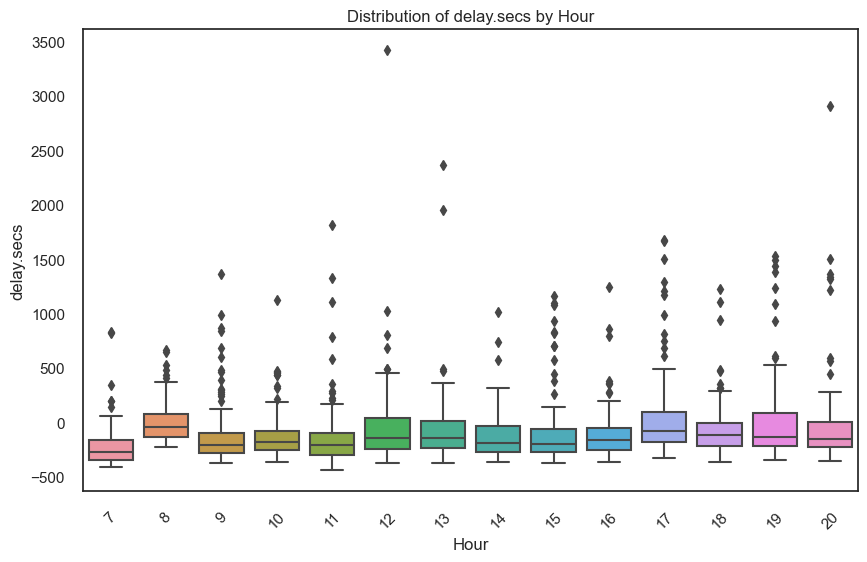

In [24]:
#我意识到车站组合真值表只对我自己比较有用，我并不把他放入我的机器学习当中，因为过站的存在性编码更重要。
def create_truth_table(train_df, test_df, onehot_columns):

    
    # Create a unique identifier for the one-hot combinations in both sets
    train_df['combination_id'] = train_df[onehot_columns].apply(lambda x: '_'.join(x.astype(str)), axis=1)
    test_df['combination_id'] = test_df[onehot_columns].apply(lambda x: '_'.join(x.astype(str)), axis=1)
    
    # Find the common combinations
    common_combinations = pd.merge(
        train_df[['combination_id']],
        test_df[['combination_id']],
        on='combination_id',
        how='inner'
    )['combination_id'].unique()
    
    # Create the truth table
    truth_table = train_df[train_df['combination_id'].isin(common_combinations)]
    
    return truth_table

# Usage
# Define the column names for the one-hot encoded features
onehot_columns = ['NORMNTN_presence','WKFLDKG_presence','WKFLDWG_presence','BNSLY_presence','MEADWHL_presence']

# Call the function with the paths to your CSV files
truth_table = create_truth_table(train_station_set,test_station_set, onehot_columns)

# The resulting 'truth_table' DataFrame will contain all rows from the training set
# that have a 'combination_id' present in both the training and testing sets.

# #观察小时和历史延时等数据的小提琴关系，效果很差。
# plot_violin_by_category(trainmatrix,category_column='Hour',value_columns=[
#            'Leeds.trains', 'Leeds.av.delay',
#        'Sheffield.trains', 'Sheffield.av.delay', 'Nottingham.trains',
#        'Nottingham.av.delay',
# ])
#观察小时和现在延误时间的观察，并没有C组那样的观测效果
# plot_distribution(trainmatrix,'Hour','delay.secs','boxplot')


In [53]:
#尝试验证分类列和目标数值列之间的显著差异性
from scipy.stats import f_oneway


df = trainmatrix
# 示例：清理包含NaN值的组
groups = [df[df['Hour'] == hour]['delay.secs'].dropna() for hour in range(7, 21)]

# 只包含非空组的ANOVA
non_empty_groups = [group for group in groups if not group.empty]
if len(non_empty_groups) > 1:  # 需要至少两组进行ANOVA
    f_statistic, p_value = f_oneway(*non_empty_groups)
    print(f"F Statistic: {f_statistic}, p-value: {p_value}")
else:
    print("Not enough non-empty groups for ANOVA")
#F Statistic: 6.573105233571209, p-value: 2.1355187679532672e-12
#如果p值小于显著性水平（如0.05），则表示不同组间存在显著差异，即分类列对目标变量具有显著的分类性。



F Statistic: 6.573105233571209, p-value: 2.1355187679532672e-12
